# Predicting Engagement and Satisfaction in Online Mental Health Platform Conversations

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10, floor, ceil
import math
import nltk
import string
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.matcher import PhraseMatcher
import joblib
from profanity_check import predict, predict_prob
import sarcastic
import csv

In [213]:
sid = SentimentIntensityAnalyzer()

nlp = spacy.load('en_core_web_sm')

pd.set_option('mode.chained_assignment',None)

# Display long column text
pd.options.display.max_colwidth = 10

In [171]:
df = pd.read_csv("data/RED/annotated/100_annotated_dialogues.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [172]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Extracting conversation, speaker, and listener

In [173]:
def extract_responses(conversation_id,subreddit):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation = conversation[conversation["subreddit"] == subreddit]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TOIMPROVE: you can only keep conversation, speaker, and listener (because others are dynamic and can be calculated from these 3)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

## Predicting engagement

In [174]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [175]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indexes
                conversation.reset_index(drop=True, inplace=True)
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [176]:
# Checks if conversation is interleaved. 
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [177]:
def calculate_engagement_score(num_turns, interleaved, sum_token_length, diff):
    num_turns_weight = 1
    interleaved_weight = 1
    token_length_weight = 0.05
    diff_weight = -1

    # Set an upper limit to token length's effect on engagement
    if sum_token_length >= 30:
        token_length_score = 30
    else:
        token_length_score = sum_token_length
    
    # Convert boolean to int
    if interleaved == True:
        interleaved_int = 1
    else:
        interleaved_int = -1
    
    return num_turns_weight*num_turns + interleaved_weight*interleaved + token_length_weight*token_length_score + diff_weight*diff

In [178]:
def classify_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    interleaved = is_interleaved_conversation(speaker, listener, conversation)
    num_turns = len(conversation)
    engagement = ""
    threshold = 4
    
    engagement_score = calculate_engagement_score(num_turns, interleaved, sum_token_length, diff)
    
    if engagement_score >= threshold:
        engagement = 1
    else:
        engagement = 0
        
    conversation['predicted_engagement'] = engagement
                    
    return num_turns, interleaved, sum_token_length, round_sig(diff), round_sig(engagement_score), engagement, conversation, threshold

## Predicting satisfaction

In [179]:
def plot_emotion_sentiment(conversation, speaker):   
    speaker_responses = conversation[conversation["author"] == speaker]
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="strongest_compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);
    plt.show()

In [180]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [181]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [182]:
# Checks if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def is_tagged_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [183]:
def is_toward_listener(speaker_response):    
    phrase_matcher = PhraseMatcher(nlp.vocab)
    phrases = ['you', 'your']
    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('toward_listener', None, *patterns)
    sentence = nlp (speaker_response)
    matched_phrases = phrase_matcher(sentence)
 
    if len(matched_phrases) > 0:
        return True

In [184]:
# Checks if any of the speaker responses, except the first, contain profanity towards the listener
def contains_profanity(conversation, speaker):
    for i in range(1,len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            for j in range(0,len(conversation['sentences'].iloc[i])):
                # i'th dialogue turn, j'th sentence
                if predict([conversation['sentences'][i][j]]) == 1 and is_toward_listener(conversation['sentences'][i][j]) == True:
                    # uncomment to print the sentence that contains profanity
                    #print(conversation['sentences'][i][j])
                    return True
    return False

In [185]:
def contains_gratitude(conversation, speaker):
 
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
    
    phrase_matcher = PhraseMatcher(nlp.vocab)
   
    phrases = ['thank', 'means a lot to me', 'thanks', 'appreciate', 'support', 'concern'
               'your help', 'means so much to me', 'grateful', 'kind of you', 'repay you', 
               'taking the time']

    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('gratitude', None, *patterns)
    sentence = nlp (speaker_responses)
    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [186]:
# Checks if any of the speaker responses, except the first, contain sarcasm
def contains_sarcasm(conversation, speaker, tokenizer, model):
    
    # Take the speaker responses except first one\
    speaker_sentences = conversation[conversation['author'] == speaker]
    speaker_sentences = speaker_sentences[speaker_sentences['dialog_turn'] != 1]
    speaker_sentences = speaker_sentences['sentences']
    sarcastic_probas = sarcastic.proba(speaker_sentences, tokenizer, model)
    #print(sarcastic_probas)
    
    # Can be optimized 
    if (sarcastic_probas > 0.6).any():
        return True
    
    return False

In [187]:
# Checks if any of the speaker responses, except the first, contain disagreement
def contains_disagreement(conversation, speaker):
        
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
    
    phrase_matcher = PhraseMatcher(nlp.vocab)
   
    phrases = ["i don't think so", "no way", "disagree", "i beg to differ", "i'd say the exact opposite", 
               "not necessarily", "that's not always true", "that's not always the case", "i'm not so sure about that", 
               "that doesn’t make much sense to me", "i don’t share your view", "i don’t agree with you"]

    patterns = [nlp(text) for text in phrases]
    phrase_matcher.add('disagreement', None, *patterns)
    sentence = nlp (speaker_responses)
    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [188]:
# Creates a column with sentence-level sentiment compounds
def sentence_level_sentiment(conversation):
    conversation['sentences'] = conversation['text'].apply(lambda x: sent_tokenize(x))
    conversation['sentences'] = conversation['sentences'].map(lambda x: list(map(str.lower, x)))
    conversation['sentence_compounds'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # sentiment compound for each sentence
        scores = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            scores[j] = sid.polarity_scores(sent_tokenize(conversation['text'][i])[j])['compound']

            conversation['sentence_compounds'][i] = scores
            
    return conversation

In [189]:
# Creates a column with the sentence compound with strongest magnitude within a dialogue turn
def strongest_sentiment(conversation):
    conversation['strongest_compound'] = conversation['sentence_compounds']
    conversation['strongest_compound'] = conversation['strongest_compound'].apply(lambda x: np.min(x) if np.max(abs(x)) == abs(np.min(x)) else np.max(x))
    
    return conversation

In [190]:
# TODO IN LATER WEEKS?
def emobert_predict_sentence_emotion(conversation):
    conversation['sentence_level_emotion_prediction'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # emotion for each sentence
        emotions = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            emotions[j] = sent_tokenize(conversation['text'][i])[j].swifter.apply(emobert_predict_emotion)
            conversation['sentence_level_emotion_prediction'][i] = emotions
            
    return conversation

In [191]:
def calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty):
    slope_weight = 1
    sentiment_change_weight = 1
    grateful_bonus_weight = 1.5
    profanity_penalty_weight = 1
    sarcasm_penalty_weight = 1
    disagreement_penalty_weight = 1.5
    
    return (slope_weight*slope + sentiment_change_weight*sentiment_change + grateful_bonus_weight*grateful_bonus + 
            profanity_penalty_weight*profanity_penalty + sarcasm_penalty_weight*sarcasm_penalty + disagreement_penalty_weight*disagreement_penalty)

In [192]:
def classify_satisfaction(conversation, speaker, tokenizer, model):
    conversation = sentence_level_sentiment(conversation)
    conversation = strongest_sentiment(conversation)
    speaker_responses = conversation[conversation["author"] == speaker]
    num_speaker_responses = len(speaker_responses)
    
    satisfaction = ""
    grateful_bonus = 0
    profanity_penalty = 0
    sarcasm_penalty = 0
    disagreement_penalty = 0
    threshold = 2
    
    # Change in sentiment from the first to the last turn
    sentiment_change = speaker_responses['strongest_compound'].iloc[-1] - speaker_responses['strongest_compound'].iloc[0]
    
    # Take the slope of the compounds of speaker responses
    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]

    if is_tagged_grateful_positive(speaker_responses)==True or contains_gratitude(speaker_responses, speaker)==True:
        grateful_bonus = 1
        
    if contains_profanity(conversation, speaker) == True:
        profanity_penalty = -1
    
    if contains_sarcasm(conversation, speaker, tokenizer, model) == True:
        sarcasm_penalty = -1    
    
    if contains_disagreement(conversation, speaker) == True:
        disagreement_penalty = -1
         
    satisfaction_score = calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty)
                                         
    if satisfaction_score >= threshold:
        satisfaction = 1
    else:
        satisfaction = 0
        
    conversation['predicted_satisfaction'] = satisfaction
        
    return round_sig(slope), round_sig(sentiment_change), grateful_bonus, profanity_penalty, sarcasm_penalty, disagreement_penalty, satisfaction_score, satisfaction, threshold

## Testing the measures on a single dialogue

In [193]:
# Train sarcastic model once
tokenizer, model = sarcastic.train()

In [194]:
def test_examples(conversation_id,subreddit):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id,subreddit)
    turns, interleaved, num_speak_tok, diff, eng_score, eng, conversation, thres_e = classify_engagement(speaker, listener, conversation)
    slope, change, grateful, profanity, sarcasm, disagree, sat_score, sat, thres_s = classify_satisfaction(conversation, speaker, tokenizer, model)
    
    plot_emotion_sentiment(conversation, speaker)
    
    print("Number of turns: ", turns, ", interleaved: ", interleaved, ", number of speaker tokens: ",  num_speak_tok, 
          ", speaker-listener turn diff: ",  diff, ", threshold: ", thres_e, ", ENGAGEMENT SCORE: ",  eng_score, ", ENGAGEMENT: ",  eng)
    
    print("Sentiment slope: ", slope, ", sentiment change: ", change, ", grateful bonus: ", grateful, 
          ", profanity penalty: ", profanity, ", sarcasm penalty: ", sarcasm, ", disagreement penalty: ", disagree, 
          ", threshold: ", thres_s, ", SATISFACTION SCORE: ", sat_score, ", SATISFACTION : ", sat) 
    
    print("Classification summary: ", eng, ", ", sat)
    
    return conversation

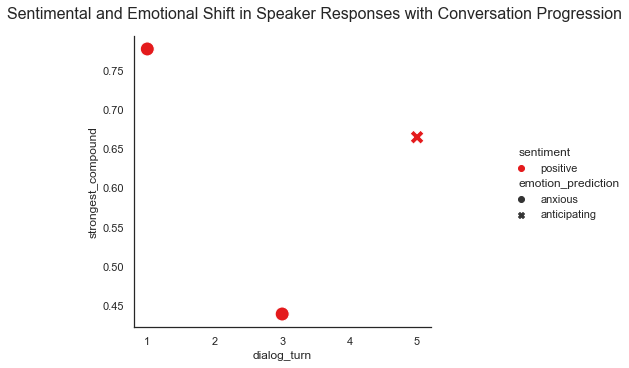

Number of turns:  6 , interleaved:  True , number of speaker tokens:  67 , speaker-listener turn diff:  None , threshold:  4 , ENGAGEMENT SCORE:  8.5 , ENGAGEMENT:  1
Sentiment slope:  -0.051 , sentiment change:  -0.11 , grateful bonus:  1 , profanity penalty:  0 , sarcasm penalty:  -1 , disagreement penalty:  0 , threshold:  2 , SATISFACTION SCORE:  0.3361749999999999 , SATISFACTION :  0
Classification summary:  1 ,  0


In [195]:
conversation = test_examples(135,"Anxietyhelp") 

In [202]:
#conversation

## Predicting on the randomly selected 100 dialogues from 8 subreddits

In [ ]:
param_grid_satisfaction = {'slope_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                          'sentiment_change_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                          'grateful_bonus_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'], 
                          'profanity_penalty_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                          'sarcasm_penalty_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                          'disagreement_penalty_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                          'sat_threshold': ['1.25', '1.5', '1.75', '2.0', '2.25'],
                          'sarcastic_probas': ['0.3', '0.4', '0.5', '0.6', '0.7']}

param_grid_engagement = {'num_turns_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                        'interleaved_weight': ['0.2', '0.4', '0.6', '0.8', '1.0'],
                        'token_length_weight': ['0.02', '0.04', '0.06', '0.08', '0.10'],
                        'diff_weight': ['-0.2', '-0.4', '-0.6', '-0.8', '-1.0'],
                        'eng_threshold': ['3.25', '3.5', '3.75', '4.0', '4.25']}

In [199]:
grouped = df.groupby(['conversation_id','subreddit']).groups
cols = df.columns.tolist()
df_preds = pd.DataFrame(columns=cols)

# Predict
for conv_id,subreddit in grouped:
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conv_id,subreddit)
    turns, interleaved, num_speak_tok, diff, eng_score, eng, conversation, thres_e = classify_engagement(speaker, listener, conversation)
    slope, change, grateful, profanity, sarcasm, disagree, sat_score, sat, thres_s = classify_satisfaction(conversation, speaker, tokenizer, model)
    
    df_preds = df_preds.append(conversation)
    
    
df_preds = df_preds[['conversation_id', 'subreddit', 'post_title', 'author', 'dialog_turn', 'text', 'ground_truth_satisfaction', 'ground_truth_engagement', 
                     'predicted_satisfaction', 'predicted_engagement', 'compound', 'sentiment', 'emotion_prediction', 'token_length', 'sentences', 'sentence_compounds', 'strongest_compound']]
    
df_preds.to_csv("data/RED/annotated/100_annotated_dialogues_with_predictions.csv", index=False)

## Testing

In [197]:
def performance(TP,FP,TN,FN):
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    f1 = 2*P*R/(P+R)
    acc = (TP+TN)/(TP+TN+FP+FN)
        
    return P, R, f1, acc

In [288]:
TP_s = 0
TN_s = 0
FP_s = 0
FN_s = 0

TP_e = 0
TN_e = 0
FP_e = 0
FN_e = 0

df_test = df_preds.copy()
grouped = df_test.groupby(['conversation_id','subreddit']).groups
first_utterances = df_test.groupby(['conversation_id', 'subreddit']).first().reset_index()

for i in range(0,len(first_utterances)):
    if ((first_utterances.iloc[i]['ground_truth_satisfaction'] == 1) & (first_utterances.iloc[i]['predicted_satisfaction'] == 1)).all():
        TP_s += 1
    elif ((first_utterances.iloc[i]['ground_truth_satisfaction'] == 0) & (first_utterances.iloc[i]['predicted_satisfaction'] == 1)).all():
        FP_s += 1
    elif ((first_utterances.iloc[i]['ground_truth_satisfaction'] == 1) & (first_utterances.iloc[i]['predicted_satisfaction'] == 0)).all():
        FN_s += 1
    else:
        TN_s += 1
        
    if ((first_utterances.iloc[i]['ground_truth_engagement'] == 1) & (first_utterances.iloc[i]['predicted_engagement'] == 1)).all():
        TP_e += 1
    elif ((first_utterances.iloc[i]['ground_truth_engagement'] == 0) & (first_utterances.iloc[i]['predicted_engagement'] == 1)).all():
        FP_e += 1
    elif ((first_utterances.iloc[i]['ground_truth_engagement'] == 1) & (first_utterances.iloc[i]['predicted_engagement'] == 0)).all():
        FN_e += 1
    else:
        TN_e += 1
        
P_s, R_s, f1_s, acc_s = performance(TP_s, FP_s, TN_s, FN_s)
P_e, R_e, f1_e, acc_e = performance(TP_e, FP_e, TN_e, FN_e)

print("SATISFACTION -- precision: ", round_sig(P_s), " recall: ", round_sig(R_s), " f1-score: ", round_sig(f1_s), " accuracy: ", round_sig(acc_s))
print("ENGAGEMENT -- precision: ", round_sig(P_e), " recall: ", round_sig(R_e), " f1-score: ", round_sig(f1_e), " accuracy: ", round_sig(acc_e))

SATISFACTION -- precision:  0.92  recall:  0.46  f1-score:  0.61  accuracy:  0.58
ENGAGEMENT -- precision:  0.9  recall:  0.81  f1-score:  0.86  accuracy:  0.75
